# 도로 영역을 찾자! - 세그멘테이션 모델 만들기

Sementic Segmentation(시맨틱 세그멘테이션)을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 모델을 만들어 보도록 하겠습니다.  
U-Net을 사용해서 이미지가 입력되면 도로의 영역을 Segmentation 하는 모델을 만들어 보겠습니다.

## 1. 시맨틱 세그멘테이션 데이터셋

### 1) 이미지, 데이터 가져오기

시맨틱 세그멘테이션(semantic segmentation)으로 도로의 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋이 필요합니다.  
KITTI 데이터셋의 세그멘테이션 데이터셋을 사용하도록 하겠습니다.

아래 그림은 데이터셋에서 확인할 수 있는 이미지와 라벨입니다. *(세그멘테이션 데이터는 이미지 형태의 라벨으로 되어있습니다.)*

**KITTI 데이터셋**
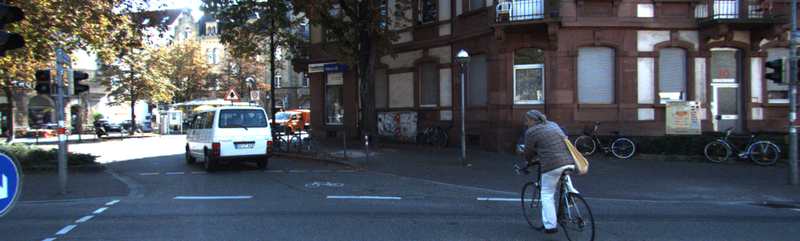

**KITTI 데이터셋 segmentation**
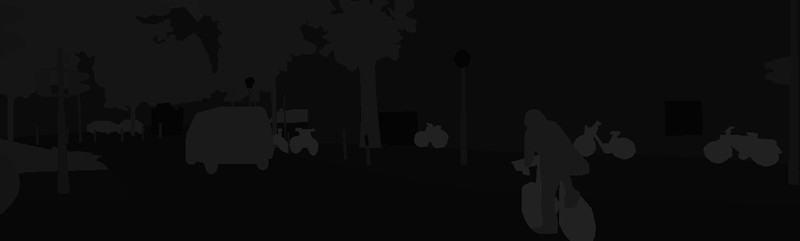

**KITTI 데이터셋 segmentation_rgb**
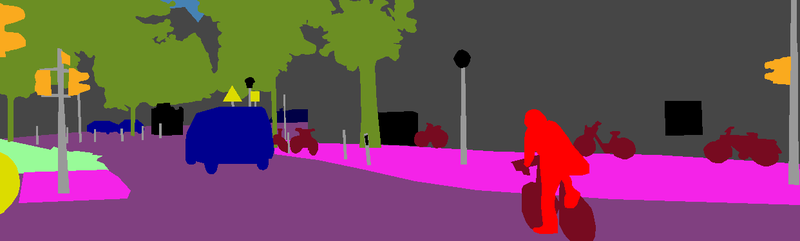

### 2) 데이터 로더(data loader) 만들기

모델을 학습시킬 수 있는 데이터 로더를 만들어 보겠습니다.  
로더는 입력값 (224, 224), 출력값 (224, 224) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야 합니다.  
이때 데이터 로더에 augmentation을 적용하도록 하겠습니다. augmentation은 `albumentations` 을 사용하도록 하겠습니다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping

# warning 무시
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

아래 코드는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 `Compose()` 의 활용 예입니다.

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

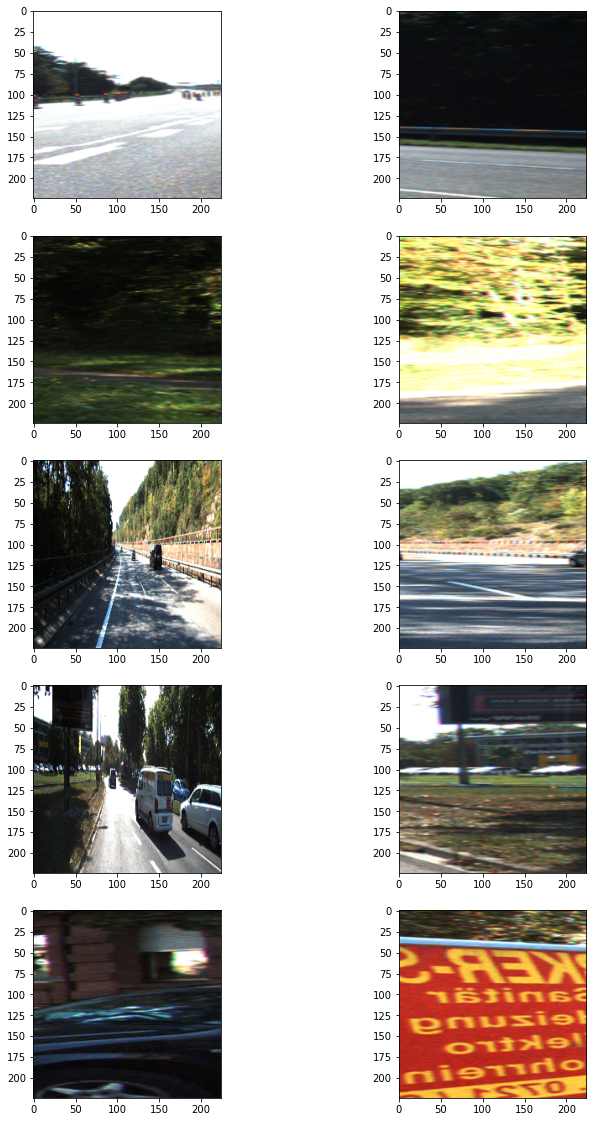

In [4]:
import os

dir_path = os.getenv('HOME')+'/aiffel/cv/04_project/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

`tf.keras.utils.Sequence` 를 상속받은 generator 형태로 데이터 셋을 구성합니다.

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                                index*self.batch_size:
                                (index + 1)*self.batch_size
                                ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 2. U-Net 시맨틱 세그멘테이션 모델 

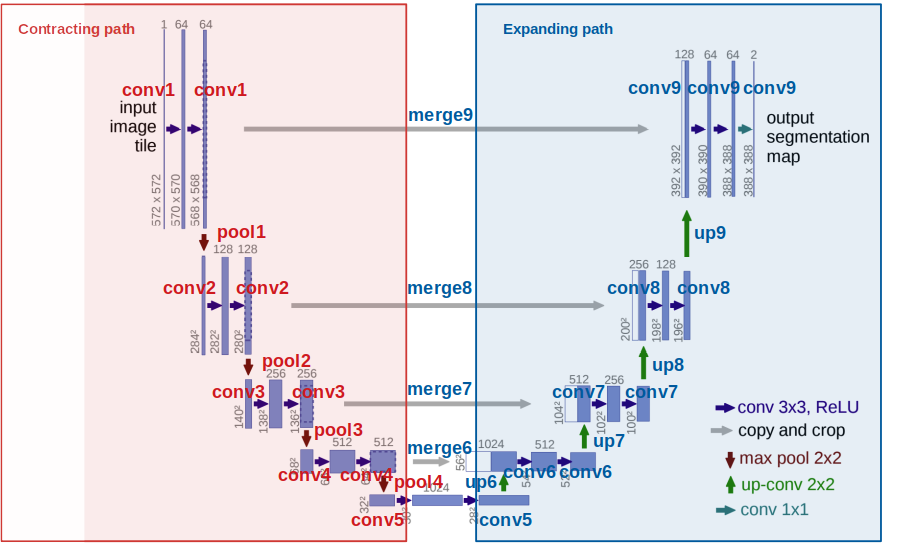

### 1) 모델 구조 만들기

> 1. 입력 이미지의 크기 : 244x244  
> 2. 필요한 레이어 : Conv2D, UpSampling2D, MaxPooling2D  
> 3. 필요한 연산 : concatenate  
> *필요에 따라서 레이어에 Dropout을 적용합니다.*

In [7]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

#Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)   
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    
    # up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    
    
    # up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    
    # up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    
    
    # up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9) 
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

### 2) 모델 학습하기

위에서 만든 데이터셋과 학습을 합니다.  
적절한 learning rate와 epoch를 찾아서 모델을 학습하고 저장하도록 하겠습니다.

In [8]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')


model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=50,
)

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

/home/aiffel-dj41/anaconda3/envs/treebit/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
43/43 [==============================] - 28s 161ms/step - loss: 0.5970 - val_loss: 0.1360
Epoch 2/50
43/43 [==============================] - 6s 147ms/step - loss: 0.1466 - val_loss: 0.1151
Epoch 3/50
43/43 [==============================] - 6s 148ms/step - loss: 0.1442 - val_loss: 0.1291
Epoch 4/50
43/43 [==============================] - 6s 148ms/step - loss: 0.1120 - val_loss: 0.1025
Epoch 5/50
43/43 [==============================] - 6s 148ms/step - loss: 0.0809 - val_loss: 0.0799
Epoch 6/50
43/43 [==============================] - 6s 149ms/step - loss: 0.0767 - val_loss: 0.0817
Epoch 7/50
43/43 [==============================] - 6s 149ms/step - loss: 0.0732 - val_loss: 0.0795
Epoch 8/50
43/43 [==============================] - 6s 150ms/step - loss: 0.0705 - val_loss: 0.0789
Epoch 9/50
43/43 [==============================] - 6s 150ms/step - loss: 0.1063 - val_loss: 0.0886
Epoch 10/50
43/43 [==============================] - 6s 149ms/step - loss: 0.0727 - val_loss: 0.078

### 3) 모델 결과 분석

테스트 셋은 이미지를 제공하지만, 정답 데이터를 제공하지 않으므로 모델이 추론한 결과를 시각화할 수 있도록 세그멘테이션 이미지를 만들어야 합니다.  
`Image.blend` 를 활용하여 입력 이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹치도록 하겠습니다.  

> *(참고) 이전 스텝에서 저장된 모델은 아래와 같이 로드해서 활용할 수 있습니다.*  
> 
> *`model = tf.keras.models.load_model(model_path)`*

In [9]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

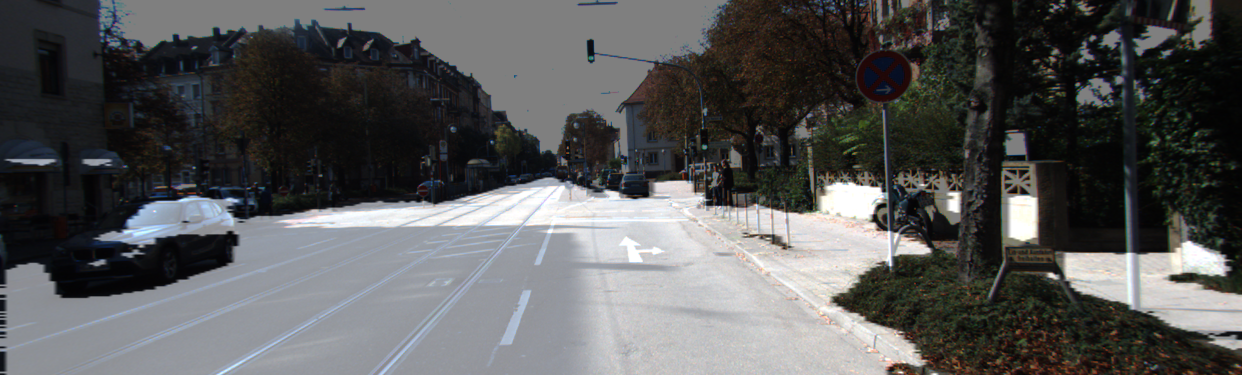

In [10]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

IoU(Intersection over Union)는 세그멘테이션의 성능을 정량적으로 측정하기 위한 방법입니다.  
IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분을 1로, 나머지 부분은 0으로 표시된 행렬이 필요합니다.  
그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다.  
각각을 prediction, target 이라고 할때, 이를 계산하는 함수를 구현해보도록 하겠습니다.  

*위에서 구현했던 get_output 을 좀 더 확장해서 output, prediction, target 을 함께 리턴하도록 구현하도록 하겠습니다.*

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output_iou(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output_iou(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.748873


0.7488732648278349

## 3. 개선된 U-Net++ 모델 만들기

### 1) 모델 구조 만들기

U-Net의 네트워크 구조에 DenseNet을 추가하여 성능을 개선한 U-Net++ 을 만들어 보도록하겠습니다.

U-Net++ 의 모델 구조는 아래 그림과 같습니다.

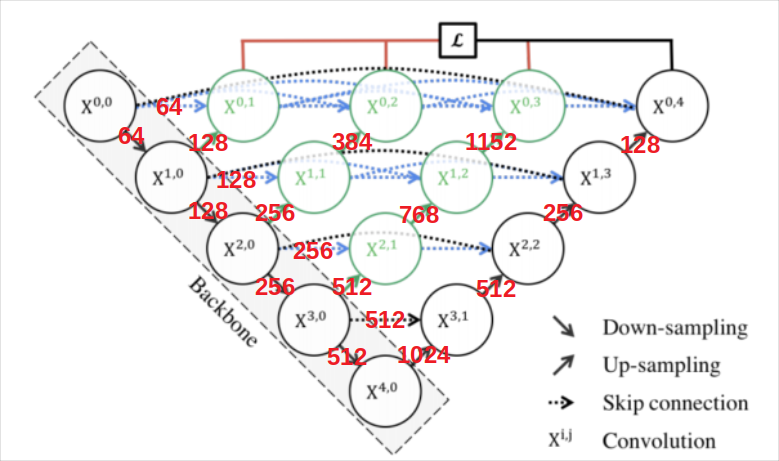

In [14]:
def build_improved_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

#Contracting Path
    x0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    x0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_0)
    x0_0 = MaxPooling2D(pool_size=(2, 2))(x0_0)
    
    x1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_0)
    x1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_0)
    x1_0 = MaxPooling2D(pool_size=(2, 2))(x1_0)
    x1_0_up = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x1_0)

    x0_1 = concatenate([x0_0,x1_0_up], axis = 3)
    
    x2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_0)
    x2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_0)
    x2_0 = MaxPooling2D(pool_size=(2, 2))(x2_0)
    x2_0_up = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x2_0)
    
    x1_1 = concatenate([x1_0,x2_0_up], axis = 3)
    x1_1_up = Conv2DTranspose(384, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x1_1)
    x0_2 = concatenate([x0_1,x1_1_up], axis = 3)
    
    x3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_0)
    x3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3_0)
    x3_0 = Dropout(0.5)(x3_0)
    x3_0 = MaxPooling2D(pool_size=(2, 2))(x3_0)
    x3_0_up = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x3_0)

    x2_1 = concatenate([x2_0,x3_0_up], axis = 3)
    x2_1_up = Conv2DTranspose(768, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x2_1)
    x1_2 = concatenate([x1_1,x2_1_up], axis = 3)
    x1_2_up = Conv2DTranspose(1152, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x1_2)
    x0_3 = concatenate([x0_2,x1_2_up], axis = 3)
      
    x4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3_0)  
    x4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x4_0)   
    x4_0 = Dropout(0.5)(x4_0)
    x4_0 = MaxPooling2D(pool_size=(2, 2))(x4_0)
    #Expanding Path
    x4_0 = Conv2DTranspose(1024, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x4_0)
    
    x3_1 = concatenate([x3_0,x4_0], axis = 3)
    x3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3_1)
    x3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3_1)
    x3_1 = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x3_1)
    
    x2_2 = concatenate([x3_1,x2_1], axis = 3)
    x2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_2)
    x2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2_2)
    x2_2 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x2_2)

    x1_3 = concatenate([x2_2,x1_2], axis = 3)
    x1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_3)
    x1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_3)
    x1_3 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x1_3)

    x0_4 = concatenate([x1_3,x0_3], axis = 3)
    x0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_4)
    x0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_4)
    x0_4 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same',kernel_initializer='he_normal')(x0_4)
    
    x0_4 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x0_4) 
    
    outputs = Conv2D(1, 1, activation='sigmoid')(x0_4)

    model = Model(inputs = inputs, outputs = outputs)
    return model

### 2) 모델 학습하기

위에서 만든 데이터셋과 학습을 합니다.  
적절한 learning rate와 epoch를 찾아서 모델을 학습하고 저장하도록 하겠습니다.

In [15]:
improved_model = build_improved_model()
improved_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

improved_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=50,
)

model_path = dir_path + '/seg_model_unet_plus.h5'
improved_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/50
43/43 [==============================] - 31s 333ms/step - loss: 0.6594 - val_loss: 0.2406
Epoch 2/50
43/43 [==============================] - 13s 306ms/step - loss: 0.1424 - val_loss: 0.1083
Epoch 3/50
43/43 [==============================] - 13s 301ms/step - loss: 0.0988 - val_loss: 0.0952
Epoch 4/50
43/43 [==============================] - 13s 301ms/step - loss: 0.0801 - val_loss: 0.0833
Epoch 5/50
43/43 [==============================] - 13s 301ms/step - loss: 0.0732 - val_loss: 0.1055
Epoch 6/50
43/43 [==============================] - 13s 303ms/step - loss: 0.0929 - val_loss: 0.0902
Epoch 7/50
43/43 [==============================] - 13s 301ms/step - loss: 0.0740 - val_loss: 0.0816
Epoch 8/50
43/43 [==============================] - 13s 302ms/step - loss: 0.0714 - val_loss: 0.0870
Epoch 9/50
43/43 [==============================] - 13s 301ms/step - loss: 0.0680 - val_loss: 0.0731
Epoch 10/50
43/43 [==============================] - 13s 301ms/step - loss: 0.0629 - val_lo

### 3) 모델 결과 분석

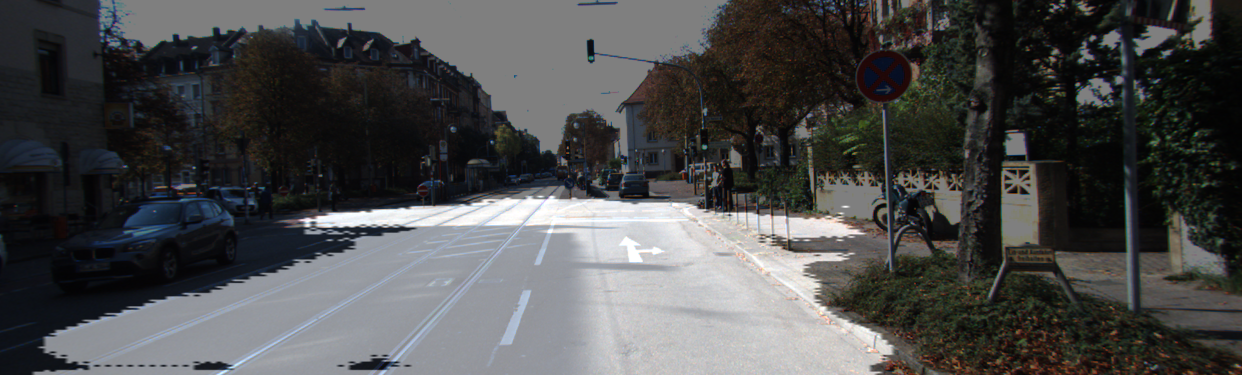

In [16]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     improved_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output_iou(
     improved_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.785630


0.7856301531213192

## 4. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

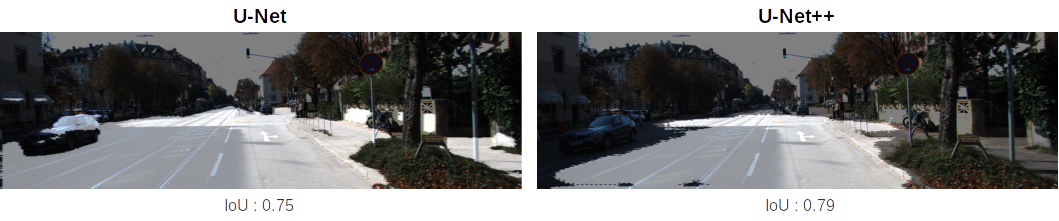

위 그림을 보시면 U-Net 모델 보다 **U-Net++ 모델** 이 성능이 더 좋음을 확인할 수 있습니다.

## 5. 루브릭

**1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?**  

    KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한사이클이 정상수행되어 세그멘테이션 결과이미지를 제출하였습니다.

**2. U-Net++ 모델이 성공적으로 구현되었는가?**  

    U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상진행되었습니다.

**3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?**  

    U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였습니다.